In [1]:
import Pkg
Pkg.activate(@__DIR__)
Pkg.instantiate()
import FiniteDiff
import ForwardDiff as FD
import Convex as cvx 
import ECOS
using LinearAlgebra
using Plots
using Random
using JLD2
using Test
using MeshCat
const mc = MeshCat
using StaticArrays
using Printf

  Activating project at `~/Course/CMU16-745-Optimal-Control-HW/hw4`


In [2]:
include(joinpath(@__DIR__, "utils","ilc_visualizer.jl"))

update_car_pose! (generic function with 1 method)

# Q1: Iterative Learning Control (ILC) (40 pts)

In this problem, you will use ILC to generate a control trajectory for a Car as it swerves to avoid a moose, also known as "the moose test" ([wikipedia](https://en.wikipedia.org/wiki/Moose_test), [video](https://www.youtube.com/watch?v=TZ2MYFInpMI)). We will model the dynamics of the car as with a simple nonlinear bicycle model, with the following state and control:

$$\begin{align} x = \begin{bmatrix} p_x \\ p_y \\ \theta \\ \delta \\ v  \end{bmatrix}, &\quad \quad u = \begin{bmatrix} a \\ \dot{\delta} \end{bmatrix}  \end{align} $$ 

where $p_x$ and $p_y$ describe the 2d position of the bike, $\theta$ is the orientation, $\delta$ is the steering angle, and $v$ is the velocity. The controls for the bike are acceleration $a$, and steering angle rate $\dot{\delta}$.  

In [3]:
function estimated_car_dynamics(model::NamedTuple, x::Vector, u::Vector)::Vector
    # nonlinear bicycle model continuous time dynamics 
    px, py, θ, δ, v = x 
    a, δdot = u 
    
    β = atan(model.lr * δ, model.L)
    s,c = sincos(θ + β)
    ω = v*cos(β)*tan(δ) / model.L
    
    vx = v*c 
    vy = v*s 
    
    xdot = [
        vx,
        vy,
        ω,
        δdot, 
        a
    ]
    
    return xdot 
end
function rk4(model::NamedTuple, ode::Function, x::Vector, u::Vector, dt::Real)::Vector
    k1 = dt * ode(model, x,        u)
    k2 = dt * ode(model, x + k1/2, u)
    k3 = dt * ode(model, x + k2/2, u)
    k4 = dt * ode(model, x + k3,   u)
    return x + (1/6)*(k1 + 2*k2 + 2*k3 + k4)
end   

rk4 (generic function with 1 method)

We have computed an optimal trajectory $X_{ref}$ and $U_{ref}$ for a moose test trajectory offline using this `estimated_car_dynamics` function. Unfortunately, this is a highly approximate dynamics model, and when we run $U_{ref}$ on the car, we get a very different trajectory than we expect. This is caused by a significant sim to real gap. Here we will show what happens when we run these controls on the true dynamics:

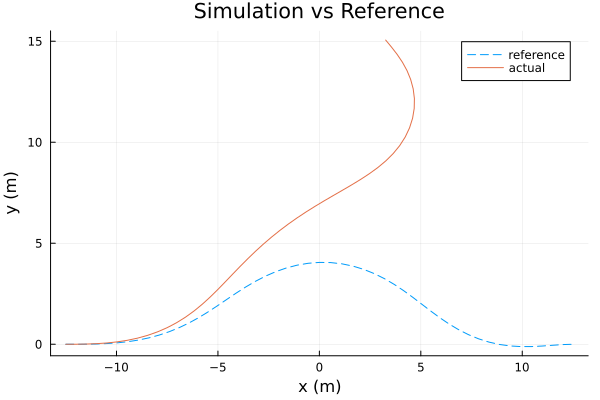

Test Summary:   | Pass  Total  Time
sim to real gap |    2      2  0.0s


Test.DefaultTestSet("sim to real gap", Any[], 2, false, false, true, 1.711227034108244e9, 1.71122703415168e9, false)

In [30]:
function load_car_trajectory()
    # load in trajectory we computed offline 
    path = joinpath(@__DIR__, "utils","init_control_car_ilc.jld2")
    F = jldopen(path)
    Xref = F["X"]
    Uref = F["U"]
    close(F)
    return Xref, Uref
end
function true_car_dynamics(model::NamedTuple, x::Vector, u::Vector)::Vector
    # true car dynamics 
    px, py, θ, δ, v = x 
    a, δdot = u 
    
    # sluggish controls (not in the approximate version)
    a = 0.9*a - 0.1 
    δdot = 0.9*δdot - .1*δ + .1
    
    β = atan(model.lr * δ, model.L)
    s,c = sincos(θ + β)
    ω = v*cos(β)*tan(δ) / model.L
    
    vx = v*c 
    vy = v*s 
    
    xdot = [
        vx,
        vy,
        ω,
        δdot, 
        a
    ]
    
    return xdot 
end

@testset "sim to real gap" begin 
    # problem size 
    nx = 5
    nu = 2
    dt = 0.1
    tf = 5.0 
    t_vec = 0:dt:tf 
    N = length(t_vec)
    model = (L = 2.8, lr = 1.6)
    
    # optimal trajectory computed offline with approximate model 
    Xref, Uref = load_car_trajectory()
    
    # TODO: simulated Uref with the true car dynamics and store the states in Xsim
    Xsim = [Xref[1]]
    for i in 1:N-1
        x = Xsim[end]
        u = Uref[i]
        xnext = rk4(model, true_car_dynamics, x, u, dt)
        push!(Xsim, xnext)
    end

    
    # --------testing------------------
    @test norm(Xsim[1] - Xref[1]) == 0 
    @test norm(Xsim[end] - [3.26801052, 15.0590156, 2.0482790, 0.39056168, 4.5],Inf) < 1e-4
    
    # --------plotting/animation-------
    Xm= hcat(Xsim...)
    Xrefm = hcat(Xref...)
    plot(Xrefm[1,:], Xrefm[2,:], ls = :dash, label = "reference",
         xlabel = "x (m)", ylabel = "y (m)", title = "Simulation vs Reference")
    display(plot!(Xm[1,:], Xm[2,:], label = "actual"))
    
end

In order to account for this, we are going to use ILC to iteratively correct our control until we converge.  

To encourage the trajectory of the bike to follow the reference, the objective value for this problem is the following:
$$  J(X,U) = \sum_{i=1}^{N-1} \bigg[ \frac{1}{2} (x_i - x_{ref,i})^TQ(x_i - x_{ref,i}) + \frac{1}{2} (u_i-u_{ref,i})^TR(u_i-u_{ref,i}) \bigg] + \frac{1}{2}(x_N - x_{ref,N})^TQ_f(x_N - x_{ref,N})$$

Using ILC as described in [Lecture 18](https://github.com/Optimal-Control-16-745/lecture-notebooks/blob/main/Lecture%2018/Lecture%2018.pdf), we are to linearize our approximate dynamics model about $X_{ref}$ and $U_{ref}$ to get the following Jacobians:

$$ A_k = \frac{\partial f}{\partial x}\bigg|_{x_{ref,k},u_{ref,k}}, \quad \quad B_k = \frac{\partial f}{\partial u}\bigg|_{x_{ref,k},u_{ref,k}} $$

where $f(x,u)$ is our **approximate discrete** dynamics model (`estimated_car_dynamics` + `rk4`). **You will form these Jacobians exactly once, using `Xref` and `Uref`.**  Here is a summary of the notation:

- $X_{ref}$ (`Xref`) -  Optimal trajectory computed offline with approximate dynamics model. 
- $U_{ref}$ (`Uref`) -  Optimal controls computed offline with approximate dynamics model. 
- $X_{sim}$ (`Xsim`) -  Simulated trajectory with real dynamics model.
- $\bar{U}$ (`Ubar`) -  Control we use for simulation with real dynamics model (this is what ILC updates).


In the second step of ILC, we solve the following optimization problem:

   $$ \begin{align} \min_{\Delta x_{1:N},\Delta u_{1:N-1}} \quad & J(X_{sim} + \Delta X, \bar{U} + \Delta U)\\ 
 \text{st} \quad & \Delta x_1 = 0 \\ 
 & \Delta x_{k+1} = A_k \Delta x_k + B_k \Delta u_k \quad \text{for } k = 1,2,\ldots,N-1 \\
 \end{align}$$
 
We are going to initialize our $\bar{U}$ with $U_{ref}$, then the ILC algorithm will update $\bar{U} = \bar{U} + \Delta U$ at each iteration. It should only take 5-10 iterations to converge down to $\|\Delta U\| < 1 \cdot 10^{-2}$. You do not need to do any sort of linesearch between ILC updates.

In [39]:
# feel free to use/not use any of these 

function trajectory_cost(Xsim::Vector{Vector{Float64}}, # simulated states 
                         Ubar::Vector{Vector{Float64}}, # simulated controls (ILC iterates this)
                         Xref::Vector{Vector{Float64}}, # reference X's we want to track
                         Uref::Vector{Vector{Float64}}, # reference U's we want to track 
                         Q::Matrix,                     # LQR tracking cost term 
                         R::Matrix,                     # LQR tracking cost term
                         Qf::Matrix                     # LQR tracking cost term
                         )::Float64                     # return cost J 
    
    J = 0 
    # TODO: return trajectory cost J(Xsim, Ubar)
    for i in 1:length(Ubar)
        J += (Xsim[i] - Xref[i])'*Q*(Xsim[i] - Xref[i]) + (Ubar[i] - Uref[i])'*R*(Ubar[i] - Uref[i])
    end
    J += (Xsim[end] - Xref[end])'*Qf*(Xsim[end] - Xref[end])
end

function vec_from_mat(Xm::Matrix)::Vector{Vector{Float64}}
    # convert a matrix into a vector of vectors 
    X = [Xm[:,i] for i = 1:size(Xm,2)]
    return X 
end

function ilc_update(Xsim::Vector{Vector{Float64}}, # simulated states 
                    Ubar::Vector{Vector{Float64}}, # simulated controls (ILC iterates this)
                    Xref::Vector{Vector{Float64}}, # reference X's we want to track
                    Uref::Vector{Vector{Float64}}, # reference U's we want to track 
                    As::Vector{Matrix{Float64}},   # vector of A jacobians at each time step 
                    Bs::Vector{Matrix{Float64}},   # vector of B jacobians at each time step 
                    Q::Matrix,                     # LQR tracking cost term 
                    R::Matrix,                     # LQR tracking cost term
                    Qf::Matrix                     # LQR tracking cost term
                    )::Vector{Vector{Float64}}     # return vector of ΔU's 

    # solve optimization problem for ILC update
    N = length(Xsim)
    nx,nu = size(Bs[1])
    
    # create variables 
    ΔX = cvx.Variable(nx, N)
    ΔU = cvx.Variable(nu, N-1)

    # TODO: cost function (tracking cost on Xref, Uref)
    cost = 0
    for i in 1:N-1
        cost += cvx.square(cvx.norm(Q^0.5 * (ΔX[:,i] - (Xref[i] - Xsim[i])))) + 
            cvx.square(cvx.norm(R^0.5 * (ΔU[:,i] - (Uref[i] - Ubar[i]))))
    end
    cost += cvx.square(cvx.norm(Qf^0.5 * (ΔX[:,N] - (Xref[N] - Xsim[N]))))
    
    # problem instance 
    prob = cvx.minimize(cost)

    # TODO: initial condition constraint
    prob.constraints += (ΔX[:,1] == zeros(nx))

    # TODO: dynamics constraints
    for i in 1:N-1
        prob.constraints += (ΔX[:,i+1] == (As[i]*ΔX[:,i] + Bs[i]*ΔU[:,i]))
    end

    cvx.solve!(prob, ECOS.Optimizer; silent_solver = true)

    # return ΔU 
    ΔU = vec_from_mat(ΔU.value)

    return ΔU
end

ilc_update (generic function with 1 method)

Here you will run your ILC algorithm. The resulting plots should show the simulated trajectory `Xsim` tracks `Xref` very closely, but there should be a significant difference between `Uref` and `Ubar`.

iter     objv        |ΔU|     
------------------------------
  1    2.872e+03   6.701e+01  
  2    1.794e+03   3.614e+01  
  3    1.590e+03   4.016e+01  
  4    9.646e+02   1.929e+01  
  5    5.250e+02   3.530e+01  
  6    1.471e+02   1.646e+01  
  7    1.997e+01   9.419e+00  
  8    5.618e-01   1.212e+00  
  9    1.429e-01   2.535e-02  
 10    1.428e-01   1.815e-04  
Test Summary: | Pass  Total  Time
ILC           |    2      2  1.4s


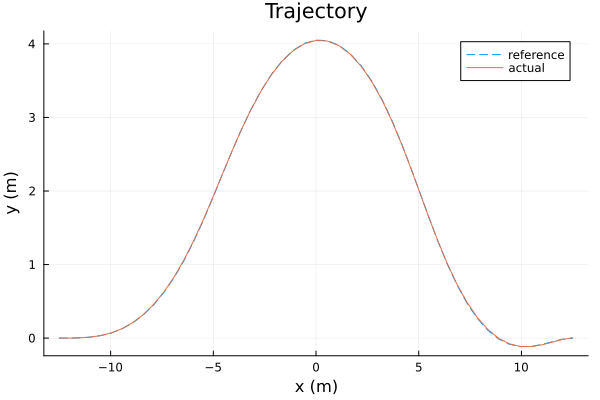

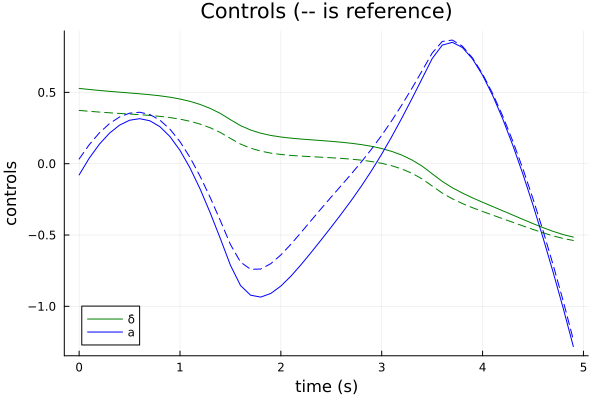

Test.DefaultTestSet("ILC", Any[], 2, false, false, true, 1.711227655894654e9, 1.711227657302288e9, false)

In [43]:
@testset "ILC" begin 
    
    # problem size 
    nx = 5
    nu = 2
    dt = 0.1
    tf = 5.0 
    t_vec = 0:dt:tf 
    N = length(t_vec)
    
    # optimal trajectory computed offline with approximate model 
    Xref, Uref = load_car_trajectory()
    
    # initial and terminal conditions 
    xic = Xref[1]
    xg = Xref[N]
    
    # LQR tracking cost to be used in ILC 
    Q = diagm([1,1,.1,.1,.1])
    R = .1*diagm(ones(nu))
    Qf = 1*diagm(ones(nx))
    
    # load all useful things into params 
    model = (L = 2.8, lr = 1.6)

    params = (Q = Q, R = R, Qf = Qf,xic = xic, xg = xg, Xref=Xref,Uref=Uref,
          dt = dt,
          N = N,
          model = model)    
    
    
    # this holds the sim trajectory (with real dynamics)
    Xsim = [zeros(nx) for i = 1:N]
    Xsim[1] = xic
    
    # this is the feedforward control ILC is updating 
    Ubar = [zeros(nu) for i = 1:(N-1)]
    Ubar .= Uref # initialize Ubar with Uref 
    
    # TODO: calculate Jacobians 
    As = [zeros(nx,nx) for i = 1:N-1]
    Bs = [zeros(nx,nu) for i = 1:N-1]
    for i in 1:N-1
        x = Xref[i]
        u = Uref[i]
        A = FD.jacobian(_x -> rk4(model, true_car_dynamics, _x, u, dt), x)
        B = FD.jacobian(_u -> rk4(model, true_car_dynamics, x, _u, dt), u)
        As[i] = A
        Bs[i] = B
    end
    
    # logging stuff 
    @printf "iter     objv        |ΔU|     \n"
    @printf "------------------------------\n"
    
    for ilc_iter = 1:10 # it should not take more than 10 iterations to converge 
        
        # TODO: rollout
        for i in 1:N-1
            Xsim[i+1] = rk4(model, true_car_dynamics, Xsim[i], Ubar[i], dt)
        end

        # TODO: calculate objective val (trajectory_cost) 
        obj_val = trajectory_cost(Xsim, Ubar, Xref, Uref, Q, R, Qf)
        
        # solve optimization problem for update (ilc_update)
        ΔU = ilc_update(Xsim, Ubar, Xref, Uref, As, Bs, Q, R, Qf)
        
        # TODO: update the control 
        Ubar = Ubar + ΔU
        
        # logging 
        @printf("%3d   %10.3e  %10.3e  \n", ilc_iter, obj_val, sum(norm.(ΔU)))
        
    end
    
    # --------plotting/animation-------
    Xm= hcat(Xsim...)
    Um = hcat(Ubar...)  
    Xrefm = hcat(Xref...)
    Urefm = hcat(Uref...) 
    plot(Xrefm[1,:], Xrefm[2,:], ls = :dash, label = "reference",
         xlabel = "x (m)", ylabel = "y (m)", title = "Trajectory")
    display(plot!(Xm[1,:], Xm[2,:], label = "actual"))
    
    plot(t_vec[1:end-1], Urefm', ls = :dash, lc = [:green :blue],label = "",
         xlabel = "time (s)", ylabel = "controls", title = "Controls (-- is reference)")
    display(plot!(t_vec[1:end-1], Um', label = ["δ̇" "a"], lc = [:green :blue]))
    
    # animation
    vis = Visualizer()
    vis_traj!(vis, :traj, [[x[1],x[2],0.1] for x in Xsim]; R = 0.02)
    build_car!(vis[:car])
    anim = mc.Animation(floor(Int,1/dt))
    for k = 1:N
        mc.atframe(anim, k) do
            update_car_pose!(vis[:car], Xsim[k])
        end
    end
    mc.setanimation!(vis, anim)
    display(render(vis))
    
    # ----------testing-------------
    @test 0.1 <= sum(norm.(Xsim - Xref)) <= 1.0 # should be ~0.7 
    @test 5 <=  sum(norm.(Ubar - Uref)) <= 10 # should be ~7.7
        
end